<a href="https://colab.research.google.com/github/Leoli04/llms-notebooks/blob/main/pytorch/60_minute_blitz/04_Training_Classifier_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

训练分类器
=====================

上一节介绍了如何构建神经网络、计算 loss 和更新网络的权值参数，接下来需要做的就是实现一个图片分类器。

关于数据疑问？
----------------

通常在处理如图片、文本、语音或者视频数据的时候，一般都采用标准的 Python 库将其加载并转成 Numpy 数组，然后再转回为 PyTorch 的张量。

-   对于图像，可以采用 Pillow, OpenCV 库；
-   对于语音，有 scipy 和 librosa;
-   对于文本，可以选择原生 Python 或者 Cython 进行加载数据，或者使用 NLTK 和 SpaCy 。

PyTorch 对于计算机视觉，特别创建了一个 torchvision 的库，它包含一个数据加载器(data loader)，可以加载比较常见的数据集，比如 Imagenet, CIFAR10, MNIST 等等，然后还有一个用于图像的数据转换器(data transformers)，调用的库是 torchvision.datasets 和 torch.utils.data.DataLoader 。


在本教程中，将采用 CIFAR10 数据集，它包含 10 个类别，分别是飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。数据集中的图片都是 3x32x32。一些例子如下所示：

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

训练图像分类器
----------------------------

训练流程如下：

1.通过调用 torchvision 加载和归一化 CIFAR10 训练集和测试集；
2.构建一个卷积神经网络；
3.定义一个损失函数；
4.在训练集上训练网络；
5.在测试集上测试网络性能。

### 1. 加载并规范化 CIFAR10数据集

我们使用torchvision 来加载，torchvision 数据集的输出是范围 [0, 1] 的 PILImage 图像。我们将它们转换为归一化范围 [-1, 1] 的张量。


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>如果在 Windows 上运行并且出现 BrokenPipeError，请尝试将 torch.utils.data.DataLoader() 的 num_worker 设置为 0.</p>
</div>




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 74242374.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


查看数据里面的训练图像


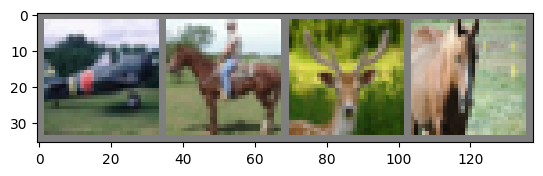

plane horse deer  horse


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. 定义卷积神经网络
========================================

这部分内容其实直接采用上一节定义的网络即可，除了修改 conv1 的输入通道，从 1 变为 3，因为这次接收的是 3 通道的彩色图片。


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. 定义损失函数和优化器
=======================================

这里采用类别交叉熵函数和带有动量的 SGD 优化方法：


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 训练网络
====================

我们只需循环数据迭代器，并将输入提供给网络并进行优化。


In [5]:
import time
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            stepTime=time.time()-start
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f},cost:{stepTime}')
            running_loss = 0.0

print('Finished Training.Total cost time: ', time.time()-start)

[1,  2000] loss: 2.168,cost:16.20243215560913
[1,  4000] loss: 1.817,cost:26.11942982673645
[1,  6000] loss: 1.647,cost:36.04866123199463
[1,  8000] loss: 1.567,cost:45.92595171928406
[1, 10000] loss: 1.494,cost:54.93360710144043
[1, 12000] loss: 1.436,cost:65.9185893535614
[2,  2000] loss: 1.350,cost:78.05648899078369
[2,  4000] loss: 1.353,cost:88.02050614356995
[2,  6000] loss: 1.314,cost:99.1158196926117
[2,  8000] loss: 1.293,cost:109.21310782432556
[2, 10000] loss: 1.278,cost:120.73461937904358
[2, 12000] loss: 1.257,cost:130.3970844745636
Finished Training.Total cost time:  132.63587188720703


保存训练好的模型：:


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)



5. 在测试数据上测试网络
====================================

训练好一个网络模型后，就需要用测试集进行测试，检验网络模型的泛化能力。对于图像分类任务来说，一般就是用准确率作为评价标准。

第一步,显示测试集中的图像数据

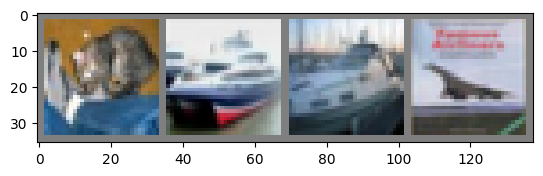

GroundTruth:  cat   ship  ship  plane


In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

接下来，加载回保存的模型，这一步不是必须的，

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

然后用这四张图片输入网络，看看网络的预测结果：


In [9]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


效果还可以，只有最后一张plane识别成了ship.让我们看看网络在整个数据集上的表现如何。


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


这看起来比概率要好得多，概率为 10%（从 10 个类别中随机选择一个类别）。

再看看是在哪些类别上识别的效果好一些：


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 51.9 %
Accuracy for class: car   is 60.8 %
Accuracy for class: bird  is 44.6 %
Accuracy for class: cat   is 46.5 %
Accuracy for class: deer  is 51.4 %
Accuracy for class: dog   is 40.0 %
Accuracy for class: frog  is 59.9 %
Accuracy for class: horse is 67.0 %
Accuracy for class: ship  is 75.5 %
Accuracy for class: truck is 71.5 %




在GPU上训练
===============

像将张量传输到 GPU 上一样，也可以将神经网络传输到 GPU 上。

首先，需要检查是否有可用的 GPU 来训练，:


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


有可用的GPU,接下来就是在 GPU 上进行训练了，其中需要修改的代码如下，分别是需要将网络参数和数据都转移到 GPU 上：

In [13]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

这里调用 net.to(device) 后，需要定义下优化器，即传入的是 CUDA 张量的网络参数。